In [1]:
import numpy as np
import py_scripts.processingIO as pio
import matplotlib.pyplot as plt
import pandas as pd

from pathlib import Path
from py_scripts.forceClass import Forces
from py_scripts.coefficientClass import Coefficients
from py_scripts.forceBinsClass import ForceBins

from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats.distributions import  t
from scipy.signal import find_peaks

from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

# Global plot parameters
plt.rcParams.update({'font.size':20, 'lines.markersize':9})
plt.rcParams.update({'mathtext.fontset':'cm'})
plt.rcParams.update({'font.family':'Times New Roman'})

In [2]:
def power_law(xData, a, b, c):
        return a + (b * xData) + (c * xData**2)

def fit_data(xData, yData):

    popt, pcov = curve_fit(power_law, xData, yData, p0=[0.5, 0.5, 0.5])

    residuals = yData - power_law(xData, *popt)

    ss_res = np.sum(residuals**2)
    ss_total = np.sum((yData-np.mean(yData))**2)

    r_squared = 1 - (ss_res/ss_total)

    return popt, r_squared

In [3]:
#data_location = r'./pimple_iteration_sensitivity'
data_location = r'./grid_independence_study'
validation_location = r'./Validation_data.xlsx'

# load the validation case data
xl = pd.ExcelFile(validation_location)
sheet_names = xl.sheet_names
Yu_cd = pd.read_excel(xl, sheet_names[0])
Yu_cl = pd.read_excel(xl, sheet_names[1])
Dong_cd = pd.read_excel(xl, sheet_names[2])
Dong_cl = pd.read_excel(xl, sheet_names[3])


In [4]:
# load the simulation data

# Flags to handle data correctly
coefficient_flag = 0
force_flag = 1
forceBin_flag = 0

coeff_paths = pio.get_files(data_location, 'coefficient.dat')
coeff_paths.sort()
force_paths = pio.get_files(data_location, 'force.dat')
force_paths.sort()
forceBins_paths = pio.get_files(data_location, 'forceBin.dat')
forceBins_paths.sort()

if coefficient_flag==1:
    # get the individual cases
    cases = []
    coeff_case = coeff_paths[0].parts[-6]
    cases.append(coeff_case)
    for coeff_file in coeff_paths:
        if coeff_file.parts[-6] != coeff_case:
            cases.append(coeff_file.parts[-6])
            coeff_case = coeff_file.parts[-6]

    # make a nice dict of all the file names based on parent case
    coeff_caseDict = dict()
    coeff_caseDict['grid'] = {}
    for case in cases:
        coeff_caseDict['grid'][case] = {}
        for coeff_file in force_paths:
            if coeff_file.parts[-7] == case:
                coeff_caseDict['grid'][case][coeff_file.parts[-6]] = coeff_file

if force_flag==1:
    # get the individual cases
    cases = []
    force_case = force_paths[0].parts[-6]
    cases.append(force_case)
    for force_file in force_paths:
        if force_file.parts[-6] != force_case:
            cases.append(force_file.parts[-6])
            force_case = force_file.parts[-6]

    # get all the folders inside the cases
    strouhals = []
    for force_file in force_paths:
        if force_file.parts[-6] == cases[0]:
            strouhals.append(force_file.parts[-6])
        else:
            break

    # make a nice dict of all the file names based on parent case
    force_caseDict = dict()
    force_caseDict['Forces'] = {}
    for case in cases:
        force_caseDict['Forces'][case] = {}
        for force_file in force_paths:
            if force_file.parts[-6] == case:
                force_caseDict['Forces'][case][force_file.parts[-6]] = force_file

if forceBin_flag is True:
    # get the individual cases
    cases = []
    forceBin_case = forceBins_paths[0].parts[-6]
    cases.append(forceBin_case)
    for forceBins_file in forceBins_paths:
        if forceBins_file.parts[-6] != forceBin_case:
            cases.append(forceBins_file.parts[-6])
            forceBin_case = forceBins_file.parts[-6]

    # get the all the folders inside the cases
    strouhals = []
    for forceBins_file in forceBins_paths:
        if forceBins_file.parts[-6] == cases[0]:
            strouhals.append(forceBins_file.parts[-6])
        else:
            break

    # make a nice dict of all the file names based on parent case
    forceBin_caseDict = dict()
    forceBin_caseDict['ForceBins'] = {}
    for case in cases:
        forceBin_caseDict['ForceBins'][case] = {}
        for forceBins_file in forceBins_paths:
            if forceBins_file.parts[-6] == case:
                forceBin_caseDict['ForceBins'][case][forceBins_file.parts[-6]] = forceBins_file

In [5]:
total_cycles = 20
number_cycles = 20
if coefficient_flag == 1:
    coeff = [Coefficients(force_path, number_cycles, total_cycles, True, True) for force_path in force_paths]
if force_flag == 1:
    forces = [Forces(force_path, number_cycles, total_cycles, True, True, filterWindow = 101) for force_path in force_paths]
if forceBin_flag == 1:
    forceBins = [ForceBins(forceBin_path, number_cycles, total_cycles, True, True) for forceBin_path in forceBins_paths]

In [6]:
density = 1026.021
U = 1.0
A = 1.0

for force in forces:
    force.toCoefficients(density, U, A)

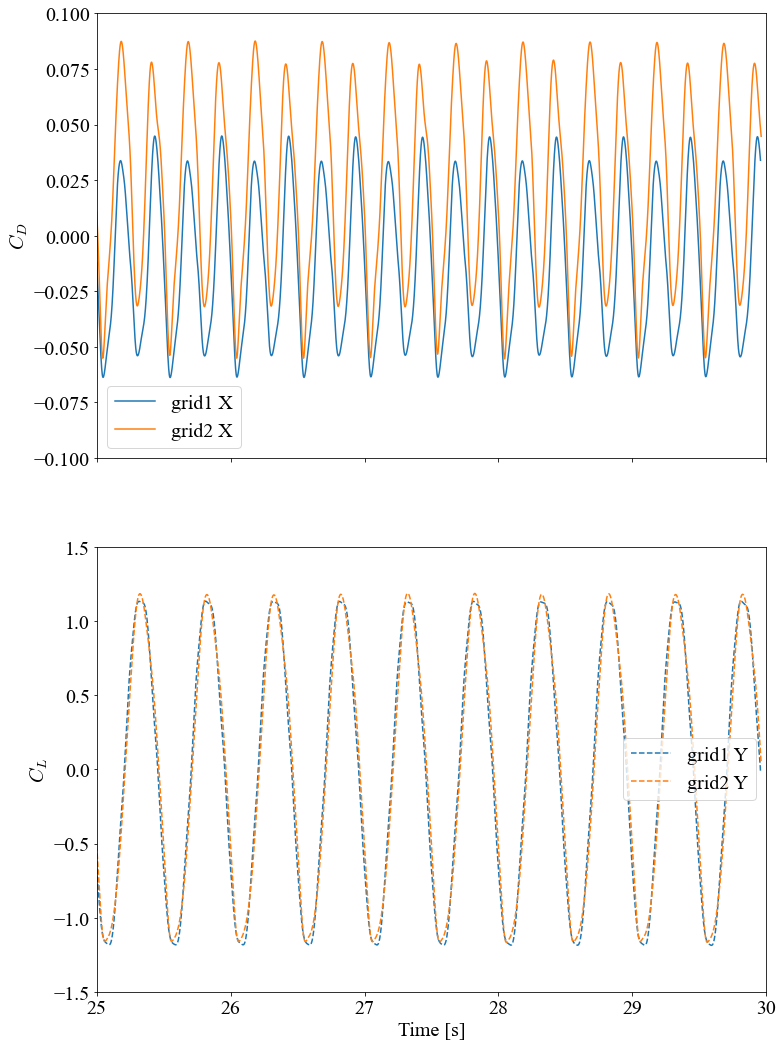

In [12]:
fig1, axs = plt.subplots(2, 1, figsize=(12,18), facecolor='w', sharex=True)
axs.flatten()

for force in forces:
    #ax2.plot(time_cd/time_cd[-1], Cd, 'r')
    axs[0].plot(force.filteredForces['time'], force.Cd, label=force.specific_case + ' X')
    
    #ax3.plot(time_cl/time_cl[-1], Cl, 'b')
    axs[1].plot(force.filteredForces['time'], force.Cl, '--', label=force.specific_case +' Y')

    axs[0].set_ylabel('$C_D$')
    #axs[0].set_xlabel('Time [s]')
    axs[0].set_ylim([-0.1, 0.1])
    axs[0].set_xlim([25, 30])
    axs[0].legend()

    axs[1].set_ylabel('$C_L$')
    axs[1].set_xlabel('Time [s]')
    axs[1].set_ylim([-1.5, 1.5])
    axs[1].set_xlim([25, 30])
    axs[1].legend()
    

In [13]:
data_location = r'./pimple_iteration_sensitivity'

force_paths = pio.get_files(data_location, 'force.dat')
force_paths.sort()

total_cycles = 20
number_cycles = 20

forces = [Forces(force_path, number_cycles, total_cycles, True, True, filterWindow = 101) for force_path in force_paths]

density = 1026.021
U = 1.0
A = 1.0

for force in forces:
    force.toCoefficients(density, U, A)

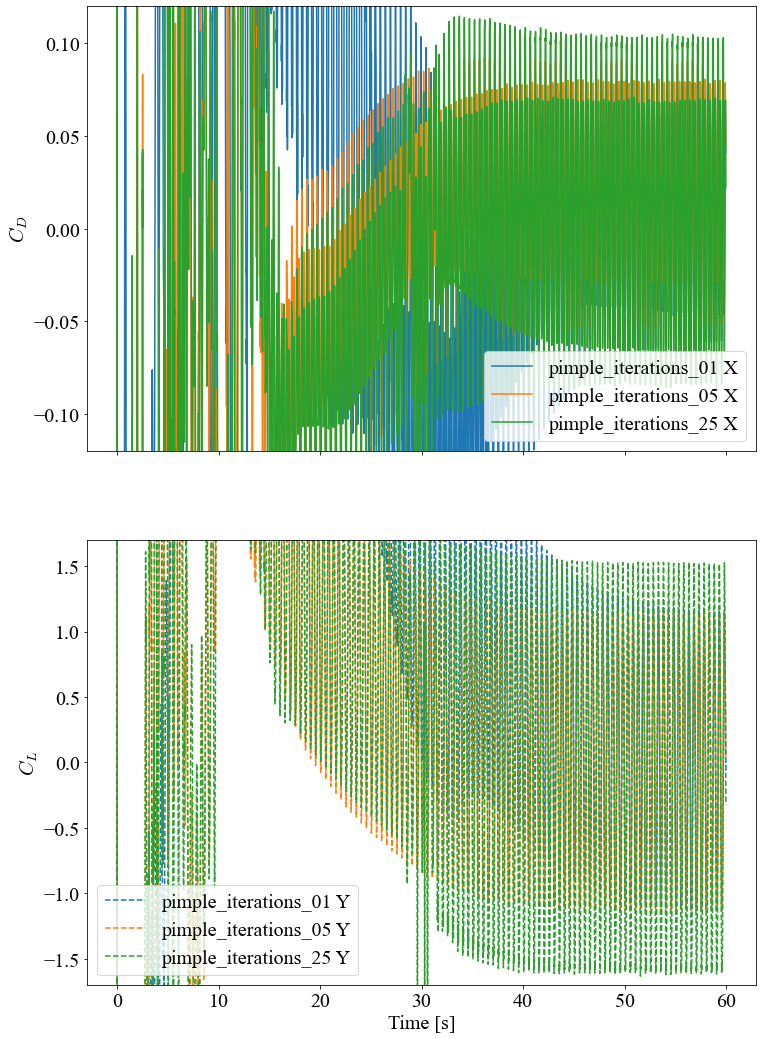

In [20]:
fig2, axs = plt.subplots(2, 1, figsize=(12,18), facecolor='w', sharex=True)
axs.flatten()

for force in forces:
    axs[0].plot(force.filteredForces['time'], force.Cd, label=force.specific_case + ' X')
    
    axs[1].plot(force.filteredForces['time'], force.Cl, '--', label=force.specific_case +' Y')

    axs[0].set_ylabel('$C_D$')
    #axs[0].set_xlabel('Time [s]')
    axs[0].set_ylim([-0.12, 0.12])
    #axs[0].set_xlim([55, 60])
    axs[0].legend()

    axs[1].set_ylabel('$C_L$')
    axs[1].set_xlabel('Time [s]')
    axs[1].set_ylim([-1.7, 1.7])
    #axs[1].set_xlim([55, 60])
    axs[1].legend()

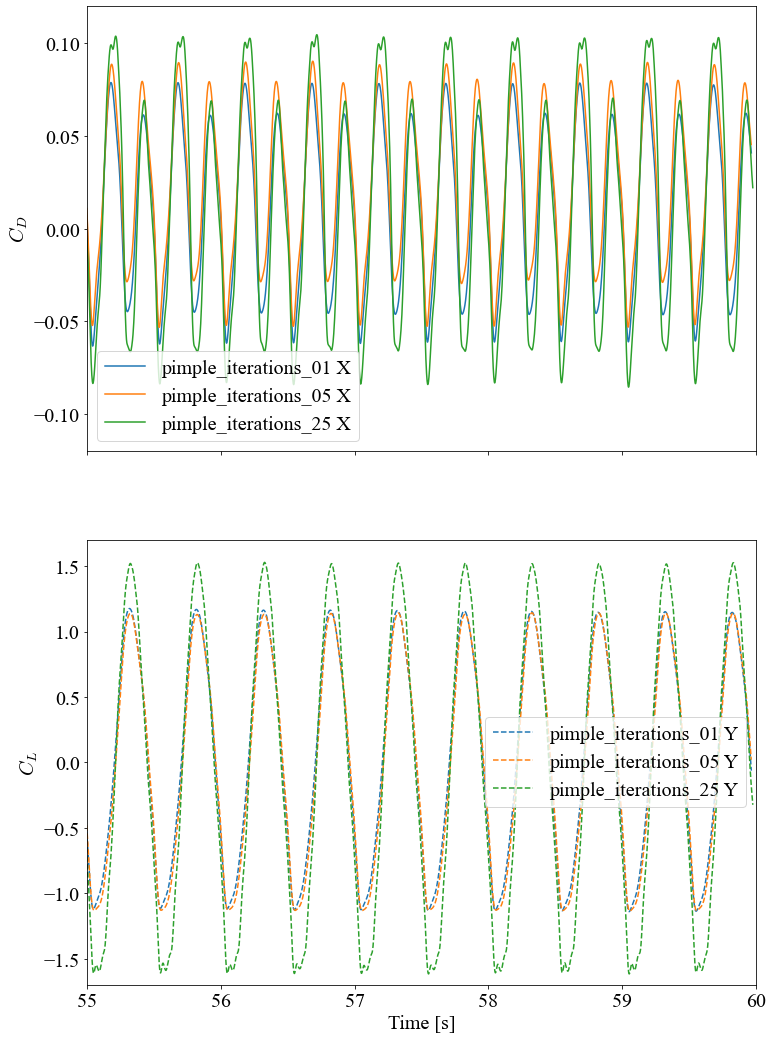

In [19]:
fig3, axs = plt.subplots(2, 1, figsize=(12,18), facecolor='w', sharex=True)
axs.flatten()

for force in forces:
    axs[0].plot(force.filteredForces['time'], force.Cd, label=force.specific_case + ' X')
    
    axs[1].plot(force.filteredForces['time'], force.Cl, '--', label=force.specific_case +' Y')

    axs[0].set_ylabel('$C_D$')
    #axs[0].set_xlabel('Time [s]')
    axs[0].set_ylim([-0.12, 0.12])
    axs[0].set_xlim([55, 60])
    axs[0].legend()

    axs[1].set_ylabel('$C_L$')
    axs[1].set_xlabel('Time [s]')
    axs[1].set_ylim([-1.7, 1.7])
    axs[1].set_xlim([55, 60])
    axs[1].legend()
    

In [ ]:
fig2, axs = plt.subplots(1, 2, figsize=(22,10), facecolor='w')
axs.flatten()

for force in forces:
    #ax2.plot(time_cd/time_cd[-1], Cd, 'r')
    axs[0].plot(force.filteredForces['time'], force.Cd, label=force.specific_case + ' X')
    
    #ax3.plot(time_cl/time_cl[-1], Cl, 'b')
    axs[1].plot(force.filteredForces['time'], force.Cl, '--', label=force.specific_case +' Y')

axs[0].set_ylabel('$\mathrm{C_D}$')
axs[0].set_xlabel('Time [s]')
axs[0].set_ylim([-0.15, 0.15])
axs[0].set_xlim([30, 60])
axs[0].legend()

axs[1].set_ylabel('$\mathrm{C_L}$')
axs[1].set_xlabel('Time [s]')
axs[1].set_ylim([-2, 2])
axs[1].set_xlim([30, 60])
axs[1].legend()

fig2.savefig('long_run_iterations_zoom.pdf', facecolor='w', dpi=300, bbox_inches='tight')
#ax1.legend(loc='best', bbox_to_anchor=(0.55, 0.9))
#ax2.legend(loc='best', bbox_to_anchor=(0.75, 0.9))

In [ ]:
fig3, axs = plt.subplots(1, 2, figsize=(22,10), facecolor='w')
axs.flatten()

for force in forces:
    #ax2.plot(time_cd/time_cd[-1], Cd, 'r')
    axs[0].plot(force.filteredForces['time'], force.Cd, label=force.specific_case + ' X')
    
    #ax3.plot(time_cl/time_cl[-1], Cl, 'b')
    axs[1].plot(force.filteredForces['time'], force.Cl, '--', label=force.specific_case +' Y')

axs[0].set_ylabel('$\mathrm{C_D}$')
axs[0].set_xlabel('Time [s]')
axs[0].set_ylim([-0.15, 0.15])
axs[0].set_xlim([50, 60])
axs[0].legend()

axs[1].set_ylabel('$\mathrm{C_L}$')
axs[1].set_xlabel('Time [s]')
axs[1].set_ylim([-2, 2])
axs[1].set_xlim([50, 60])
axs[1].legend()

fig2.savefig('long_run_iterations_zoom_end.pdf', facecolor='w', dpi=300, bbox_inches='tight')
#ax1.legend(loc='best', bbox_to_anchor=(0.55, 0.9))
#ax2.legend(loc='best', bbox_to_anchor=(0.75, 0.9))

In [ ]:
total_cycles = 60
number_cycles = 3
if coefficient_flag == 1:
    coeff = [Coefficients(force_path, number_cycles, total_cycles, True, True) for force_path in force_paths]
if force_flag == 1:
    forces = [Forces(force_path, number_cycles, total_cycles, True, True, filterType='hanning', filterWindow = 101) for force_path in force_paths]
if forceBin_flag == 1:
    forceBins = [ForceBins(forceBin_path, number_cycles, total_cycles, True, True) for forceBin_path in forceBins_paths]

In [ ]:
density = 1027
U = 1.0
A = 1.0

for force in forces:
    force.toCoefficients(density, U, A)

In [ ]:
plt.rcParams.update({'font.size':18})
figure_location = r'./'


fig1, ax1 = plt.subplots(figsize=(12,10))
ax2 = ax1.twinx()

for force in forces:
    ax1.plot(force.specific_case, np.mean(force.Cd), 'ro', label='$C_D$')
    ax2.plot(force.specific_case, np.mean(force.Cl), 'bo', label='$C_L$')

ax1.plot("Yu", np.mean(Yu_cd['CD']), 'ro')
ax2.plot("Yu", np.mean(Yu_cl['CL']), 'bo')
ax1.plot("Dong", np.mean(Dong_cd['CD']), 'ro')
ax2.plot("Dong", np.mean(Dong_cl['CL']), 'bo')

ax1.set_xlabel('Case')
ax1.grid()
ax1.set_ylabel('$C_D$')
ax2.set_ylabel('$C_L$')
#ax1.legend(ncol=2, bbox_to_anchor=(0.09, 0.99))
#ax2.legend()
#fig2.savefig(Path(figure_location).joinpath('AvgPower_St.png'))

In [ ]:
percent_error_cd = []
percent_error_cl = []

for force in forces:
    percent_error_cd.append(np.abs(np.mean(force.Cd)*3 - np.mean(Dong_cd['CD']))/np.mean(Dong_cd['CD']))
    percent_error_cl.append(np.abs(np.mean(force.Cl) - np.mean(Dong_cl['CL']))/np.mean(Dong_cl['CL']))

print(percent_error_cd, percent_error_cl)

In [ ]:
fig2, ax2 = plt.subplots(figsize=(12,10))
ax3 = ax2.twinx()

ax2.plot(Yu_cd['time'], -Yu_cd['CD'], 'b+', label='Yu $C_D$')
ax2.plot(Dong_cd['time'], Dong_cd['CD'], 'b^', label='Dong $C_D$')

ax3.plot(Yu_cl['time'], Yu_cl['CL'], 'r+', label='Yu $C_D$')
ax3.plot(Dong_cl['time'], Dong_cl['CL'], 'r^', label='Dong $C_D$')

slice_start = np.array([575, 675, 725, 800])
slice_end = np.array([1650, 1750, 1875, 2000])

for i, force in enumerate(forces): 
    time_vector = force.filteredForces['time'][slice_start[i]:slice_end[i]]
    time_vector = time_vector-time_vector[0]
    Cd = force.Cd[slice_start[i]:slice_end[i]]
    Cl = force.Cl[slice_start[i]:slice_end[i]]
    ax2.plot(time_vector/time_vector[-1], Cd, label=force.specific_case + ' drag')
    
    ax3.plot(time_vector/time_vector[-1], Cl, '--', label=force.specific_case +' lift')

    ax2.set_ylabel('$C_D$')
    ax2.set_ylim([-0.5, 0.5])
    ax3.set_ylabel('$C_L$')
    ax3.set_ylim([-2, 2])
    ax2.legend()
    ax3.legend()

In [ ]:
fig3, ax3 = plt.subplots(figsize=(12,10))

for force in forces:
    ax3.plot(force.filteredForces['time'], force.Cd, 'k-')
    ax3.plot(force.filteredForces['time'], force.Cdf, 'k:')
    ax3.plot(force.filteredForces['time'], force.Cdp, 'k--')

In [ ]:
cd_error = []
cl_error = []
fine_cd = np.max(forces[-1].Cd)
fine_cl = np.max(forces[-1].Cl)
for force in forces:
    cd_error.append(np.abs(np.max(force.Cd)-fine_cd)/fine_cd*100)
    cl_error.append(np.abs(np.max(force.Cl)-fine_cl)/fine_cl*100)

print(cd_error, cl_error)